In [2]:
#!pip install photutils
#!pip install matplotlib
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import *

from photutils.background import Background2D, MedianBackground #Photutils is another package used to manipulate images and find sources in our images.
from photutils.detection import DAOStarFinder #Photutils documentation: https://photutils.readthedocs.io/en/stable/
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

#import warnings
#warnings.filterwarnings('ignore')

In [3]:
prefix1 = "/Volumes/LaCie/phys_134l/ubi_lsc/10_25_lsc/lsc0m412-kb85-20231025-00"
prefix2 = "/Volumes/LaCie/phys_134l/ubi_lsc/10_25_lsc/lsc0m412-kb85-20231025-0"
suffix = "-e91.fits"
files = [prefix1+str(i)+suffix for i in range(97,100)]
files2 = [prefix2+str(i)+suffix for i in range(100,117)]
files = files + files2
nimages = len(files)
images  = []
headers = []
for i in range(nimages):
    image = fits.open(files[i])[0].data
    header = fits.open(files[i])[0].header
    images.append(image)
    headers.append(header)

In [4]:
prefix1 = "/Volumes/LaCie/phys_134l/ust_ogg/10_25_ogg/tfn0m410-kb24-20231025-0"
suffix = "-e91.fits"
files = [prefix1+str(i)+suffix for i in range(175,195)]
nimages = len(files)
images_ust_1025  = []
headers_ust_1025 = []
for i in range(nimages):
    image = fits.open(files[i])[0].data
    header = fits.open(files[i])[0].header
    images_ust_1025.append(image)
    headers_ust_1025.append(header)

In [5]:
print("UBI 10/25: ")
for i in range(nimages):
    header = headers[i]
    filt = header['FILTER']
    print("image %d uses filter: " %i, filt)
print("UST 10/25: ")
for i in range(nimages):
    header = headers_ust_1025[i]
    filt = header['FILTER']
    print("image %d uses filter: " %i, filt)

UBI 10/25: 
image 0 uses filter:  B
image 1 uses filter:  B
image 2 uses filter:  B
image 3 uses filter:  B
image 4 uses filter:  B
image 5 uses filter:  B
image 6 uses filter:  B
image 7 uses filter:  B
image 8 uses filter:  B
image 9 uses filter:  B
image 10 uses filter:  V
image 11 uses filter:  V
image 12 uses filter:  V
image 13 uses filter:  V
image 14 uses filter:  V
image 15 uses filter:  V
image 16 uses filter:  V
image 17 uses filter:  V
image 18 uses filter:  V
image 19 uses filter:  V
UST 10/25: 
image 0 uses filter:  B
image 1 uses filter:  B
image 2 uses filter:  B
image 3 uses filter:  B
image 4 uses filter:  B
image 5 uses filter:  B
image 6 uses filter:  B
image 7 uses filter:  B
image 8 uses filter:  B
image 9 uses filter:  B
image 10 uses filter:  V
image 11 uses filter:  V
image 12 uses filter:  V
image 13 uses filter:  V
image 14 uses filter:  V
image 15 uses filter:  V
image 16 uses filter:  V
image 17 uses filter:  V
image 18 uses filter:  V
image 19 uses filter:

In [6]:
# try adding images linearly:
im_B = images[0]
im_V = images[10]
for i in range(nimages//2):
    im_B += images[i+1]
    im_V += images[i+10]

In [7]:
im_B_ust_1025 = images_ust_1025[0]
im_V_ust_1025 = images_ust_1025[10]
for i in range(nimages//2):
    im_B_ust_1025 += images_ust_1025[i+1]
    im_V_ust_1025 += images_ust_1025[i+10]

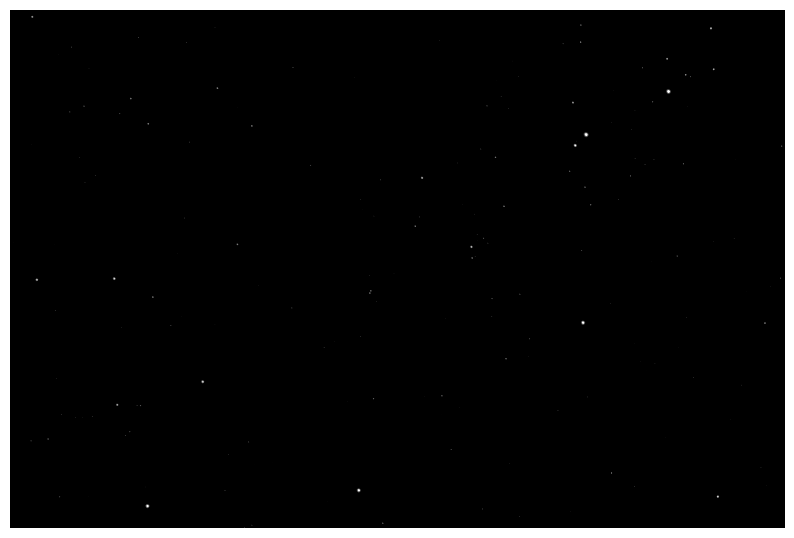

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs(images[10])),
          origin='lower',
          cmap='gray',
          vmin=7, vmax=11)
plt.axis('off')
plt.show()

# Final Image: V band

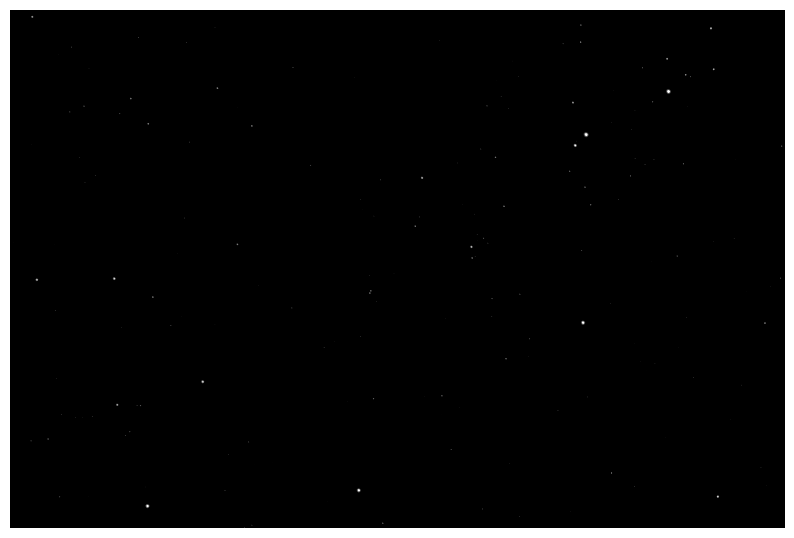

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs(im_V)),
          origin='lower',
          cmap='gray',
          vmin=7, vmax=11)
plt.axis('off')
plt.show()

# Final Image: B band

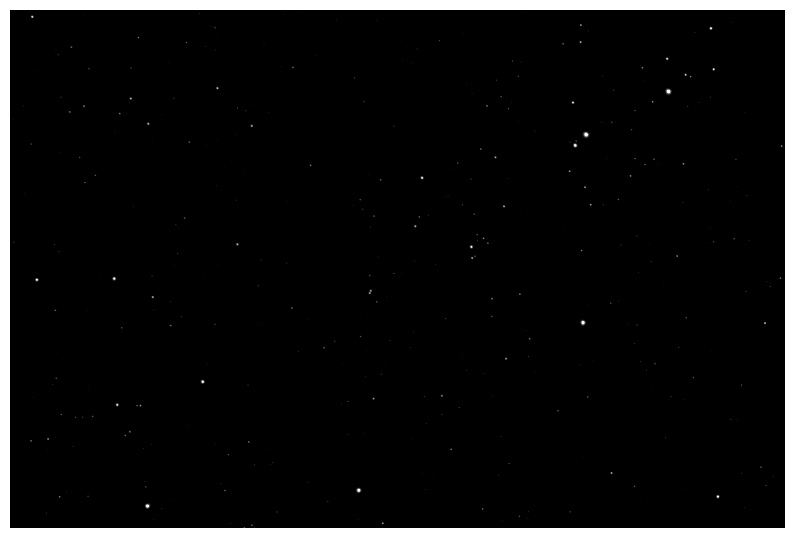

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs(im_B)),
          origin='lower',
          cmap='gray',
          vmin=8, vmax=11)
plt.axis('off')
plt.show()

# Final Image, V Band, 10/25 UST

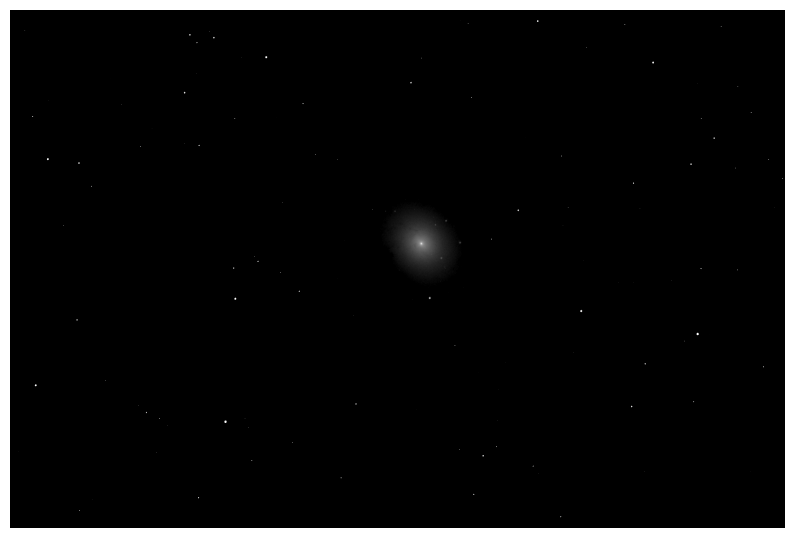

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs(im_V_ust_1025)),
          origin='lower',
          cmap='gray',
          vmin=7, vmax=10)
plt.axis('off')
plt.show()

In [22]:
#In order to run photometry we need to first process our images.

#First we ned to do some statistics
sigma_clip = SigmaClip(sigma=3.0) #A sigma clip excludes values that are a certain number of standatd deviations, sigma, above the mean. We don't include these in our background because they're stars.
mean, median, std = sigma_clipped_stats(im_V, sigma=3.0) #Here astropy just does some statistics for us. Use the same sigma as you choose for the clip. 3 is usually good.

bkg_estimator = MedianBackground() #This specifies which method of estimating the background photutils uses. We almost always want to stick with median.
bkg = Background2D(im_V, #Which image to make a background for
                    box_size=(50, 50), #Box size tells the function how much of the image to parse at once. Leave it at 50x50 usually.
                    filter_size=(3, 3), #3x3 is default for the filter size. I honestly don't know what a 'median filter' is, but this has always worked.
                    sigma_clip=sigma_clip, #Just use the sigma clip we defined earlier.
                    bkg_estimator=bkg_estimator) #Same thing for the background estimator method.
bkg_median = bkg.background_median #This pulls the median of the background values.

In [52]:
#Now let's find some sources using DAO Star Finder.

daofind = DAOStarFinder(fwhm=10, #This is the full width half maximum of the 'gaussian kernel' of the starfinder in units of pixels. Smaller values will find more sources, large values will find less.
                        threshold=7*std) #The threshold determines at what pixel value the starfinder will call something a source. We usually use a multiple of the standard deviation we found earlier. Again smaller for more.
# sources = daofind(image - bkg_median)
sources = daofind(im_V)
print(sources)

 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1  963.2171528471013 ...  4.580994129180908   -1.6523993380049495
  2 2269.1220313472368 ... 2.9576849937438965   -1.1773797947034688
  3 5.7537266607730775 ...   2.44429612159729   -0.9703845466690322
  4  3048.457801102823 ... 2.5790774822235107   -1.0286609741861028
  5 1192.9369259059781 ...  1.096665859222412  -0.10018580867901682
  6 1153.2934909948506 ... 1.0545353889465332 -0.057652896808749875
  7  919.2389036787838 ... 1.5391523838043213  -0.46820404822910544
...                ... ...                ...                   ...
267 1351.3084903550862 ... 2.7718379497528076   -1.1069195911974108
268  87.48695723149508 ... 111.42058563232422    -5.117413592008848
269 293.97183102553197 ...  2.369778633117676   -0.9367694484581781
270   746.329808849658 ...  4.229448318481445   -1.5657093062244947
271 1150.6679511706575 ... 2.6928083896636963   

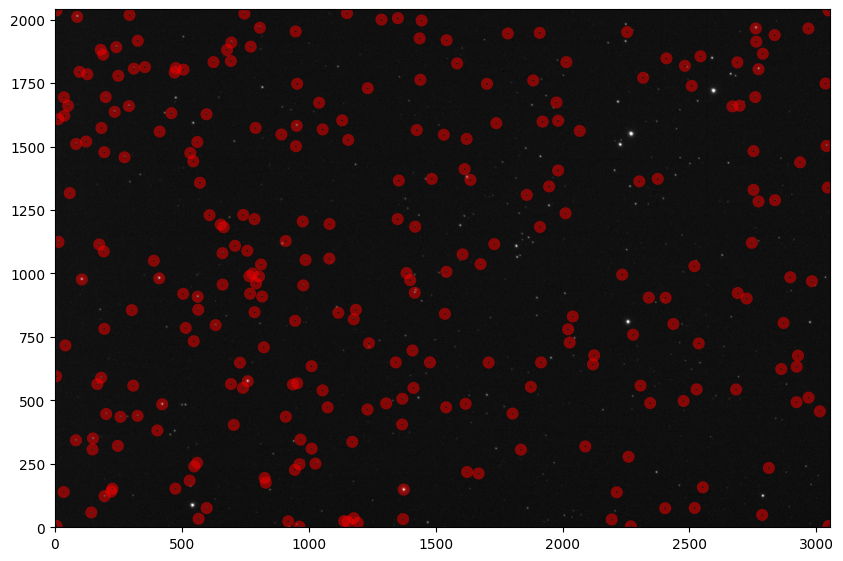

In [53]:
#Now we know where our sources are, we can do some aperture photometry to get values of their brightness.

positions = np.transpose((sources['xcentroid'], sources['ycentroid'])) #Positions are transposed by default.
apertures = CircularAperture(positions, r=10) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs(im_V)), origin='lower', cmap = "gray", vmin=6, vmax = 11)
v = apertures.plot(color='red', lw=5, alpha=0.5) #I define it as a variable to avoid unnecessary readout.
plt.show()

In [54]:
#We can make a photometry table using the aperture photometry function.
phot_table = aperture_photometry(im_V - bkg_median, apertures) #We use the aperture photometry function to list the photon sums and positions of the sources we found.
print(phot_table)

 id      xcenter            ycenter           aperture_sum   
           pix                pix                            
--- ------------------ ------------------ -------------------
  1  963.2171528471013 2.3392667051088605  17555.861445011877
  2 2269.1220313472368  3.143384113846971  3957.7866377912505
  3 5.7537266607730775  4.719790678811267  -736.1766701768829
  4  3048.457801102823  4.532103490266589 -3982.1482795745433
  5 1192.9369259059781 16.985650322771136  101.52355286456509
  6 1153.2934909948506 21.988867485275616   960.6819165463648
...                ...                ...                 ...
267 1351.3084903550862 2005.8102555427836  10591.593629418294
268  87.48695723149508     2010.709432644   542856.5941143006
269 293.97183102553197 2018.1779328673729  14088.388123432795
270   746.329808849658 2023.7520775565074   19885.14063988605
271 1150.6679511706575 2025.4832731253268  14736.703201751472
272  5.978141410523938 2036.2956691391048   4241.014795155865
273 3048

In [55]:
def photometry(data, header, fwhm=5, thresh=5*std):
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    time = header["MJD-OBS"] #I am simply returning the modified julian date off the header for convenience.
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    bkg = Background2D(data, box_size=(50, 50), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    bkg_median = bkg.background_median
    daofind = DAOStarFinder(fwhm=fwhm, threshold=thresh)
    sources = daofind(data - bkg_median)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=15)
    phot_table = aperture_photometry(data - bkg_median, apertures)
    aperture_sums = phot_table['aperture_sum']
    return time, positions, aperture_sums

In [56]:
time, positions, sums = photometry(image, header)
print("We found", len(sums), "stars")

#Lets call a random star and see what information we found on it.
star_index = np.random.randint(0,len(sums))
star_position = positions[star_index]
star_photons = sums[star_index]
print("The star's pixel position is", star_position)
print("The star's photon count is", star_photons)

We found 126 stars
The star's pixel position is [2969.08579867  633.80223005]
The star's photon count is 17056.138637370645


In [79]:
brightest_stars_i = [i for i in range(len(sums)) if sums[i] >50000]
print(brightest_stars_i)
print(len(brightest_stars_i))

bright_positions = [positions[i] for i in brightest_stars_i]
print(bright_positions)
bright_x = [bright_positions[i][0] for i in range(len(bright_positions))]
bright_y = [bright_positions[i][1] for i in range(len(bright_positions))]

[23, 29, 34, 44, 47, 48, 49, 64, 68, 70, 82, 85, 104, 107, 109, 112, 116, 117, 123]
19
[array([848.89793726, 417.66956056]), array([2449.31134253,  477.48016458]), array([101.15702887, 560.80913204]), array([2709.36991993,  762.53119253]), array([2250.37993653,  852.97999684]), array([887.53318863, 901.45716336]), array([1653.70897244,  904.28255273]), array([1620.59845451, 1118.46112349]), array([1717.9081491 , 1208.07078362]), array([2002.41335658, 1249.27061099]), array([ 271.50226519, 1435.18842509]), array([ 148.87970851, 1450.5862568 ]), array([ 687.76079301, 1712.08262562]), array([1579.70844297, 1751.5387022 ]), array([2533.7905772 , 1830.64728195]), array([1009.29203496, 1851.82439935]), array([ 803.1052208 , 1928.66954225]), array([ 708.47701433, 1939.82068311]), array([2078.96908151, 1993.72356082])]


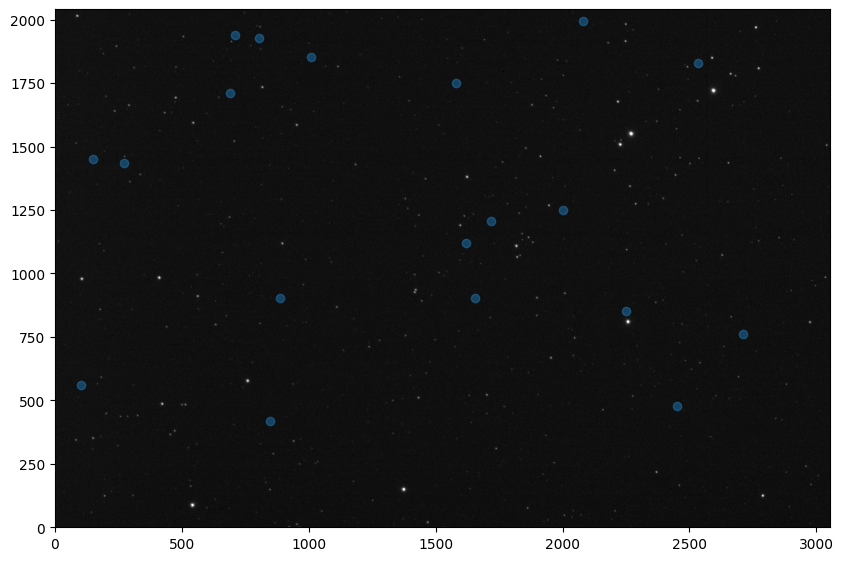

In [80]:

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs(im_V)), origin='lower', cmap = "gray", vmin=6, vmax = 11)
plt.plot(bright_x,bright_y, linestyle='',marker='o',alpha=0.5)
#v = apertures.plot(color='red', lw=5, alpha=0.5) #I define it as a variable to avoid unnecessary readout.
plt.show()

In [1]:
prefix1 = "/Volumes/LaCie/phys_134l/ubi_lsc/november/11_2_lsc/lsc0m412-kb85-20231102-00"
suffix = "-e91.fits"
files = [prefix1+str(i)+suffix for i in range(58,98)]
nimages = len(files)
images_ubi_1025  = []
headers_ubi_1025 = []
for i in range(nimages):
    image = fits.open(files[i])[0].data
    header = fits.open(files[i])[0].header
    images_ubi_1025.append(image)
    headers_ubi_1025.append(header)

for i in range(nimages):
    header = headers_ubi_1025[i]
    exp = header['EXPTIME']
    date = header['DATE-OBS']
    print("image %d integration time: " %i, exp)


NameError: name 'fits' is not defined

In [9]:
print(headers_ubi_1025[0])

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 3054                                                  NAXIS2  =                 2042                                                  EXTEND  =                    T                                                  DATADICV= 'LCOGT-DIC.FITS-0.11.0' / Version number of the data dictionary       HDRVER  = 'LCOGT-HDR-1.4.0'    / Version number of the headers                  ORIGIN  = 'LCOGT   '           / Organization responsible for the data          SITEID  = 'lsc     '           / ID code of the Observatory site                SITE    = 'LCOGT node at Cerro Tololo Inter-American Observatory' / Site of the ENCID   = 'aqwb    '           / ID code of the Enclosure                       ENCLOSUR= 'Aqawan-03'          / Buildin

In [19]:
for i in range(nimages):
    header = headers_ubi_1025[i]
    exp = header['EXPTIME']
    date = header['DATE-OBS']
    print("image %d integration time: " %i, exp)

image 0 integration time:  40.237
image 1 integration time:  40.236
image 2 integration time:  40.236
image 3 integration time:  40.233
image 4 integration time:  40.234
image 5 integration time:  40.237
image 6 integration time:  40.235
image 7 integration time:  40.233
image 8 integration time:  40.235
image 9 integration time:  40.233
image 10 integration time:  40.236
image 11 integration time:  40.237
image 12 integration time:  40.234
image 13 integration time:  40.237
image 14 integration time:  40.236
image 15 integration time:  40.237
image 16 integration time:  40.233
image 17 integration time:  40.237
image 18 integration time:  40.237
image 19 integration time:  40.236
image 20 integration time:  40.236
image 21 integration time:  40.236
image 22 integration time:  40.237
image 23 integration time:  40.234
image 24 integration time:  40.236
image 25 integration time:  40.236
image 26 integration time:  40.236
image 27 integration time:  40.236
image 28 integration time:  40

In [15]:
print(headers_ubi_1025)

[]


In [30]:
pref = "/Volumes/LaCie/phys_134l/ubi_lsc/"
nums = [1027, 1029, 1031, 112, 114, 116, 118]
suffix = ".fits"
files = [pref+str(i)+suffix for i in nums]
nimages = len(files)
images_ubi  = []
headers_ubi = []
for i in range(nimages):
    image = fits.open(files[i])[0].data
    header = fits.open(files[i])[0].header
    images_ubi.append(image)
    headers_ubi.append(header)

for i in range(nimages):
    header = headers_ubi[i]
    exp = header['EXPTIME']
    date = header['DATE-OBS']
    print("Date: %s, Integration time: " %date, exp)


Date: 2023-10-27T23:59:08.523, Integration time:  40.282
Date: 2023-10-30T00:18:54.564, Integration time:  40.237
Date: 2023-11-01T00:12:15.768, Integration time:  40.237
Date: 2023-11-03T00:18:32.351, Integration time:  40.237
Date: 2023-11-03T01:02:41.913, Integration time:  40.237
Date: 2023-11-07T00:34:13.904, Integration time:  40.232
Date: 2023-11-09T00:19:54.084, Integration time:  40.237
